<a href="https://colab.research.google.com/github/SamT2023/Flooding/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing the libraries
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
import os
import datetime
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from copy import deepcopy
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import itertools
import random

In [2]:
def lagged_dataset(arr, num_steps, additional_arr, new_num_steps):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []
    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)
    result_array = np.array(modified_rows)
    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row[:-1]))  # Exclude last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    return final_result, np.array(excluded_data)[:, None]

def lagged_dataset_pron(arr, num_steps, additional_arr, new_num_steps, lead_time):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []

    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)

    result_array = np.array(modified_rows)

    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row))  # Include last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Shift excluded_data by lead_time
    excluded_data = excluded_data[lead_time:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    # Resize final_result and excluded_data to have the same number of rows
    min_rows = min(final_result.shape[0], excluded_data.shape[0])
    final_result = final_result[:min_rows]
    excluded_data = excluded_data[:min_rows]

    return final_result, np.array(excluded_data)[:, None]


def calculate_hydro_metrics(simulations, evaluation):
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    rmse = np.sqrt(np.mean((evaluation - simulations) ** 2,
                            axis=0, dtype=np.float64))
    pbias = (100 * np.sum(evaluation - simulations, axis=0, dtype=np.float64)
              / np.sum(evaluation))
    r2 = 1 - (np.sum((evaluation - simulations)**2) / np.sum((evaluation - np.mean(evaluation))**2))
    return kge, rmse, pbias, r2
np.random.seed(22)
random.seed(22)

In [10]:
#select the  folder
folder = os.getcwd()+'/data/'
folder

'/content/data/'

In [14]:
# Import satellite precipitation data by taking the correct file path
precipitation_satellite = pd.read_table('/content/PERSIANN-CCS_UTC_daily_catchment_1.csv', sep=',')

In [15]:
# Rename columns
precipitation_satellite.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
# Convert the 'Date' column to datetime format
precipitation_satellite['Date'] = precipitation_satellite['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
# Set 'Date' as the index
precipitation_satellite.set_index(precipitation_satellite['Date'], inplace=True)
# Drop the redundant 'Date' column (updated for future pandas versions)
precipitation_satellite = precipitation_satellite.drop(labels='Date', axis=1)

<ipython-input-15-f65800af28ff>:4: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  precipitation_satellite['Date'] = precipitation_satellite['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))


In [16]:
#Display the precipitation
precipitation_satellite

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-02-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-03-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-04-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-05-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-08,0.0,0.2,0.48,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,1.2,0.0,0.0,1.41,0.5,0.0,1.22,5.22,2.12,0.5
2023-10-08,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2023-11-08,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0


In [17]:
precipitation_satellite.describe()

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
count,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,...,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000,7523.000000
mean,1.974199,1.997146,2.059567,2.000225,2.016677,2.037310,2.155702,2.270837,2.031273,2.106984,...,2.337712,2.445254,2.554990,2.045331,2.177743,2.316866,2.384750,2.538837,2.290659,2.386830
std,6.544445,6.451735,6.254302,6.649823,6.507294,5.854176,5.915903,6.816839,6.328158,7.001304,...,6.995166,7.061795,6.954125,5.821780,6.095927,6.642359,6.487665,7.945365,6.221511,6.446545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.700000,0.790000,0.820000,0.590000,0.685000,0.835000,0.935000,1.065000,0.690000,0.870000,...,1.080000,1.210000,1.255000,0.785000,0.930000,1.060000,1.150000,1.225000,0.955000,1.095000
max,261.090000,261.390000,218.730000,230.290000,261.470000,80.020000,69.760000,250.440000,179.000000,333.540000,...,261.810000,184.230000,106.900000,77.950000,109.370000,132.630000,91.010000,332.380000,104.740000,96.500000


In [18]:
precipitation_satellite.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7526 entries, 2003-01-01 to 2023-08-13
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       7523 non-null   float64
 1   2       7523 non-null   float64
 2   3       7523 non-null   float64
 3   6       7523 non-null   float64
 4   7       7523 non-null   float64
 5   8       7523 non-null   float64
 6   9       7523 non-null   float64
 7   10      7523 non-null   float64
 8   12      7523 non-null   float64
 9   13      7523 non-null   float64
 10  14      7523 non-null   float64
 11  15      7523 non-null   float64
 12  16      7523 non-null   float64
 13  17      7523 non-null   float64
 14  18      7523 non-null   float64
 15  19      7523 non-null   float64
 16  20      7523 non-null   float64
 17  21      7523 non-null   float64
 18  22      7523 non-null   float64
 19  23      7523 non-null   float64
 20  24      7523 non-null   float64
 21  25      7523 non-nu

In [19]:
#Calculating the annual preciptation
data_annual = precipitation_satellite.resample('Y',label='right',closed='right').sum()

<ipython-input-19-d26e15c89a47>:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data_annual = precipitation_satellite.resample('Y',label='right',closed='right').sum()


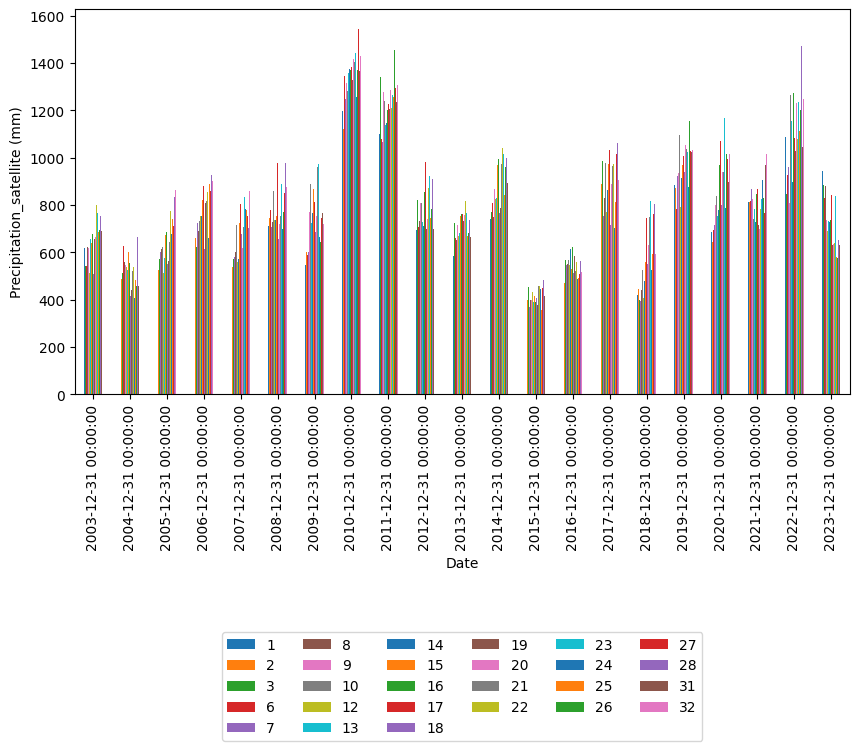

In [20]:
#ploting the annual preceipitation
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

In [21]:
#calculate the annual average precipitation for all pexicels in  the basin
data_annual_average =  data_annual.mean(axis=1)
data_annual_average

,0
Date,
2003-12-31,646.573704
2004-12-31,518.426667
2005-12-31,647.289630
2006-12-31,785.916296
2007-12-31,688.204074
2008-12-31,783.095185
2009-12-31,757.777407
2010-12-31,1350.764074
2011-12-31,1214.637037


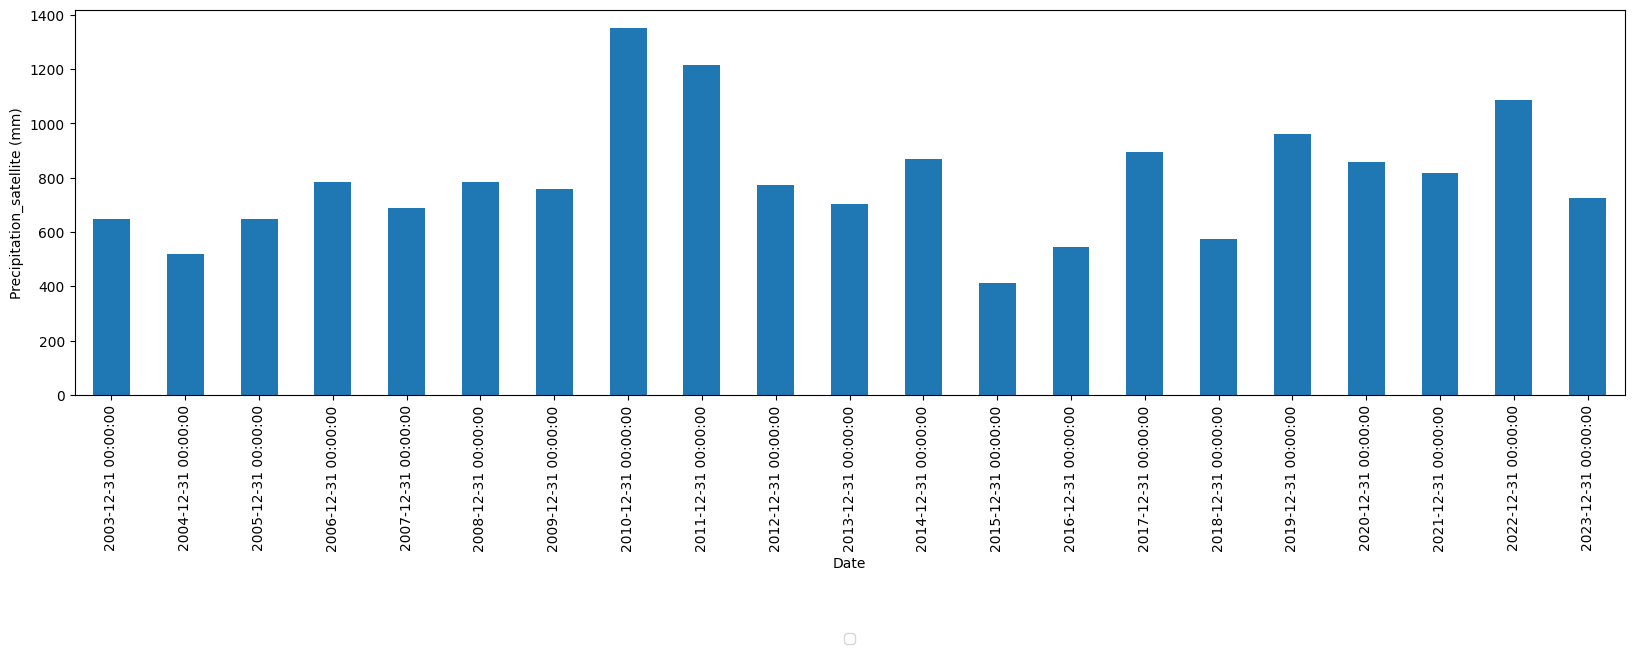

In [22]:
#Plot the average annual precipitation in pixel
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual_average.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

In [23]:
#Calculate the average annual precipitation in the basin
data_annual_average.mean()

791.1507054652682

In [24]:
#calculate monthly precipitation
data_monthly = precipitation_satellite.resample('M',label='right',closed='right').sum()
data_monthly

<ipython-input-24-a837a2730de3>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = precipitation_satellite.resample('M',label='right',closed='right').sum()


,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-31,71.13,79.23,90.52,79.31,94.56,100.01,100.48,103.50,86.73,98.21,...,106.06,115.80,124.34,88.36,98.92,115.90,112.22,106.98,107.05,114.01
2003-02-28,76.79,77.77,40.85,40.84,50.44,75.22,54.14,51.34,40.31,66.36,...,57.33,48.25,41.78,56.68,58.98,48.34,56.71,47.17,59.27,74.09
2003-03-31,40.24,40.53,67.38,39.60,46.39,46.71,52.10,58.60,39.75,45.47,...,135.31,124.22,98.48,44.53,65.15,76.95,108.39,121.63,72.58,92.35
2003-04-30,78.87,55.39,50.21,128.39,125.00,84.61,64.48,107.86,63.57,77.05,...,100.43,143.71,81.55,87.49,109.85,106.17,68.19,124.85,105.56,157.66
2003-05-31,4.44,29.95,39.42,9.25,7.85,14.16,41.07,8.95,7.40,52.22,...,0.32,4.17,37.23,1.32,9.88,14.07,2.23,11.58,2.84,4.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,33.57,45.76,60.67,35.71,31.21,39.51,54.63,41.53,33.08,41.36,...,56.49,41.46,51.54,29.84,36.20,41.04,39.94,49.85,40.88,43.10
2023-09-30,32.16,57.28,62.52,24.77,21.78,51.13,42.90,13.86,18.23,16.81,...,17.68,13.66,13.61,19.84,13.10,13.41,17.97,23.97,14.91,16.37
2023-10-31,32.46,31.81,31.17,30.93,29.26,27.77,26.94,29.60,28.84,27.01,...,24.38,19.99,20.04,18.36,21.52,24.82,24.49,28.87,16.74,19.25


In [25]:
#Calculate monthly precipitation
data_monthly_mean_pixels =  data_monthly.mean(axis=1)
data_monthly_mean_pixels

,0
Date,
2003-01-31,100.150000
2003-02-28,55.087037
2003-03-31,67.702593
2003-04-30,95.465185
2003-05-31,12.847778
...,...
2023-08-31,42.542222
2023-09-30,23.684815
2023-10-31,25.874074


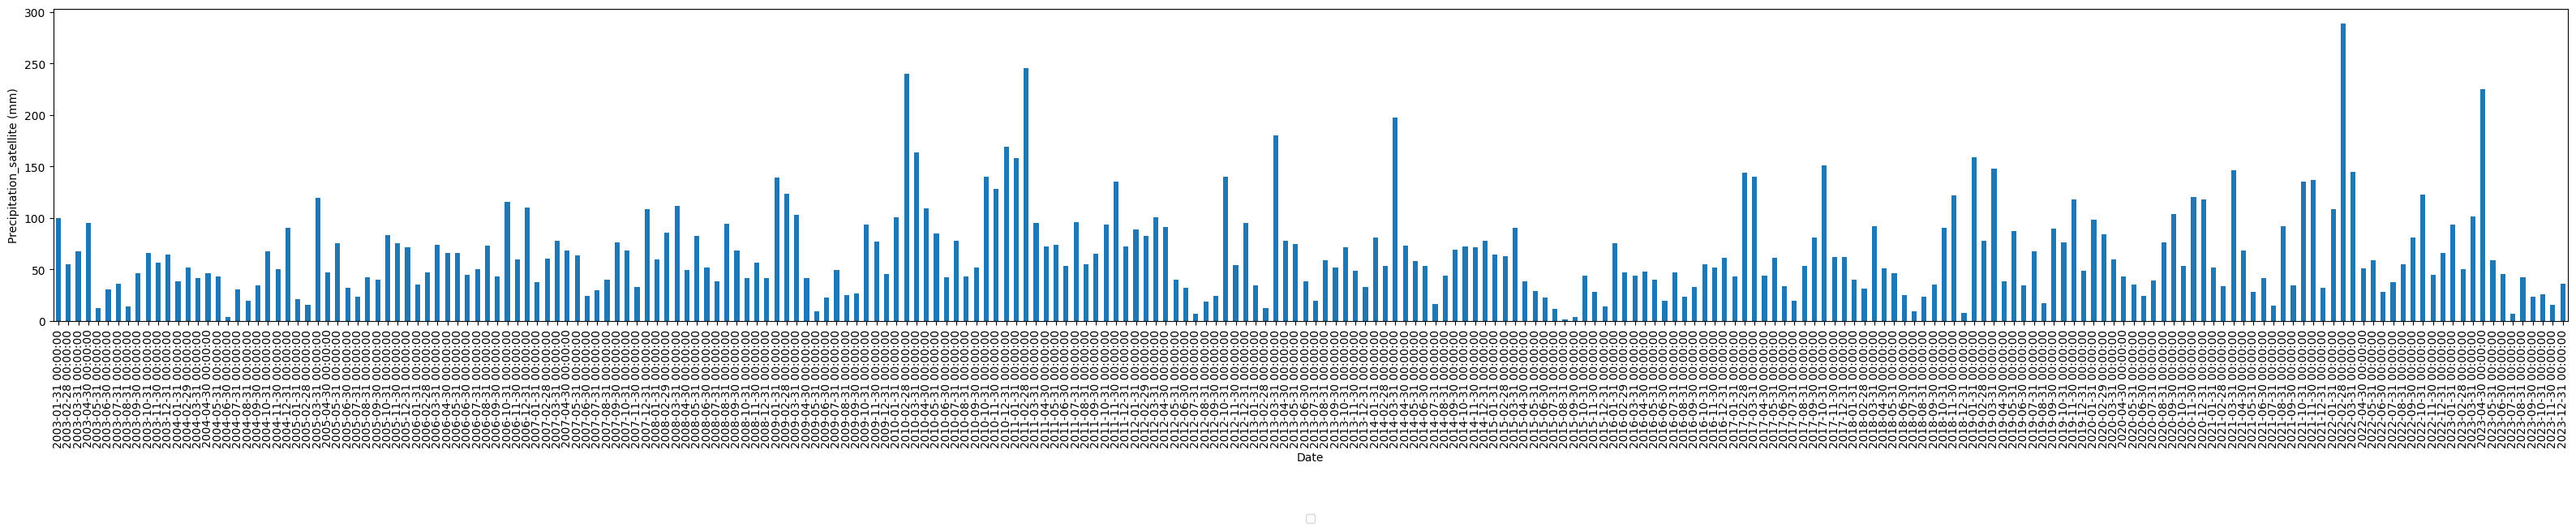

In [26]:
#plot
fig, ax = plt.subplots(figsize=(40,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean_pixels.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

In [27]:
#calculate the average monthly precipitation(average of all pixel in the basin)
data_monthly_mean= data_monthly_mean_pixels.groupby(data_monthly_mean_pixels.index.month).mean()
data_monthly_mean

,0
Date,
1,77.576085
2,90.227055
3,109.490265
4,68.889365
5,53.804780
6,33.610899
7,34.807531
8,43.531728
9,51.637090


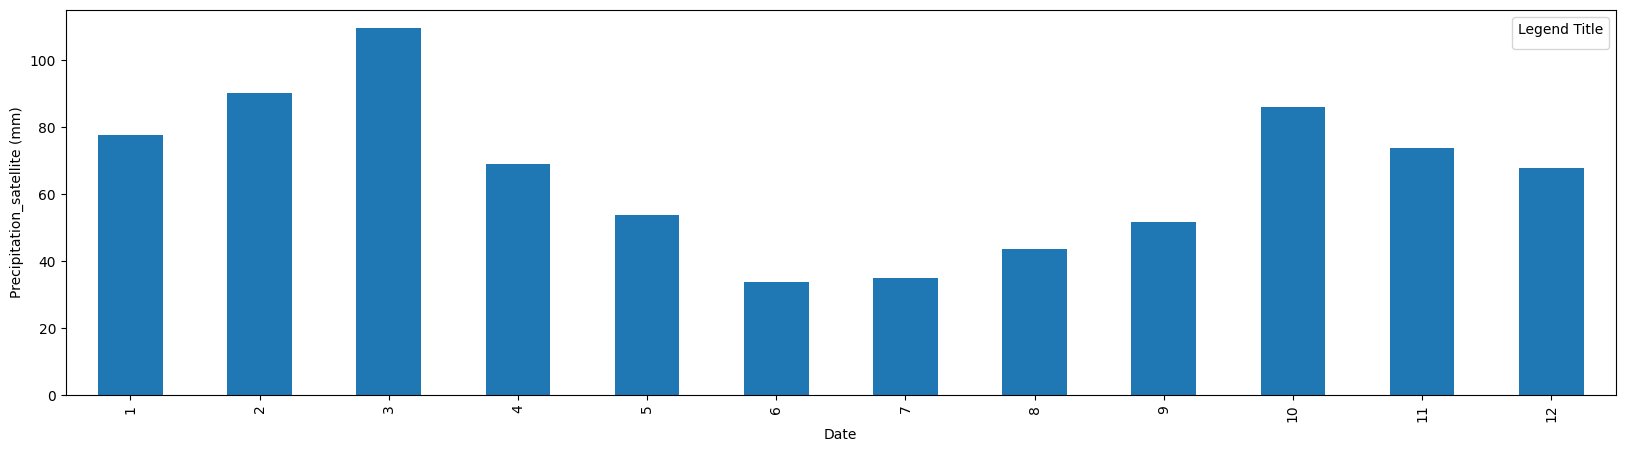

In [28]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
plt.show()

AttributeError: 'float' object has no attribute 'min'

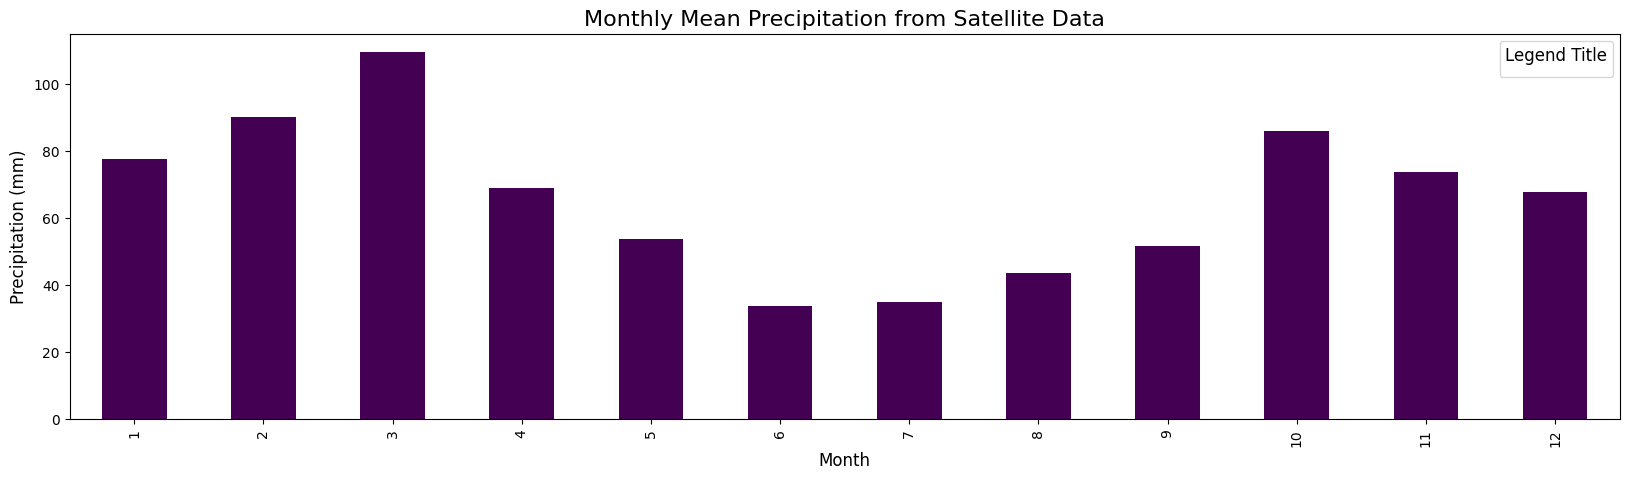

In [29]:
import matplotlib.pyplot as plt

# Assuming 'data_monthly_mean' is a pandas DataFrame with labeled columns
fig, ax = plt.subplots(figsize=(20, 5))

# Plotting the data
data_monthly_mean.plot(kind='bar', ax=ax, colormap='viridis')

# Adding a plot title
ax.set_title('Monthly Mean Precipitation from Satellite Data', fontsize=16)

# Adding a label to the y-axis
ax.set_ylabel('Precipitation (mm)', fontsize=12)

# Adding a label to the x-axis
ax.set_xlabel('Month', fontsize=12)

# Adding and customizing the legend
ax.legend(title='Legend Title', fontsize=10, title_fontsize='12')

# If the plot uses a colormap, add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=data_monthly_mean.min().min(), vmax=data_monthly_mean.max().max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Precipitation Intensity', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [32]:
#import the insuti sttation data
folder_pcp_1 = '/content/Rain_gauge_1.csv'
df_pcp_1= pd.read_table('/content/Rain_gauge_1.csv', sep=',')
df_pcp_1.rename(columns={'Texas_tip_corrected_mm':'Pluviómetro_1'},inplace=True)
df_pcp_1.columns
df_pcp_1

,Date_yy/mm/dd_hh:mm:ss,Pluviómetro_1
0,2012-10-02 12:00:00,NaN
1,2012-10-02 13:00:00,0.0
2,2012-10-02 14:00:00,0.0
3,2012-10-02 15:00:00,0.0
4,2012-10-02 16:00:00,0.0
...,...,...
95638,2023-08-31 10:00:00,0.0
95639,2023-08-31 11:00:00,0.0
95640,2023-08-31 12:00:00,0.0
95641,2023-08-31 13:00:00,0.0


In [33]:
#operation to get data into manageable dataframe
# Rename the column 'Date_yy/mm/dd_hh:mm:ss' to 'Date'
df_pcp_1.rename(columns={'Date_yy/mm/dd_hh:mm:ss': 'Date'}, inplace=True)
# Convert the 'Date' column to datetime format
df_pcp_1['Date'] = df_pcp_1['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
# Set the 'Date' column as the index
df_pcp_1.set_index('Date', inplace=True)
df_pcp_1

<ipython-input-33-6152441548c7>:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_pcp_1['Date'] = df_pcp_1['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))


,Pluviómetro_1
Date,
2012-02-10 12:00:00,NaN
2012-02-10 13:00:00,0.0
2012-02-10 14:00:00,0.0
2012-02-10 15:00:00,0.0
2012-02-10 16:00:00,0.0
...,...
2023-08-31 10:00:00,0.0
2023-08-31 11:00:00,0.0
2023-08-31 12:00:00,0.0


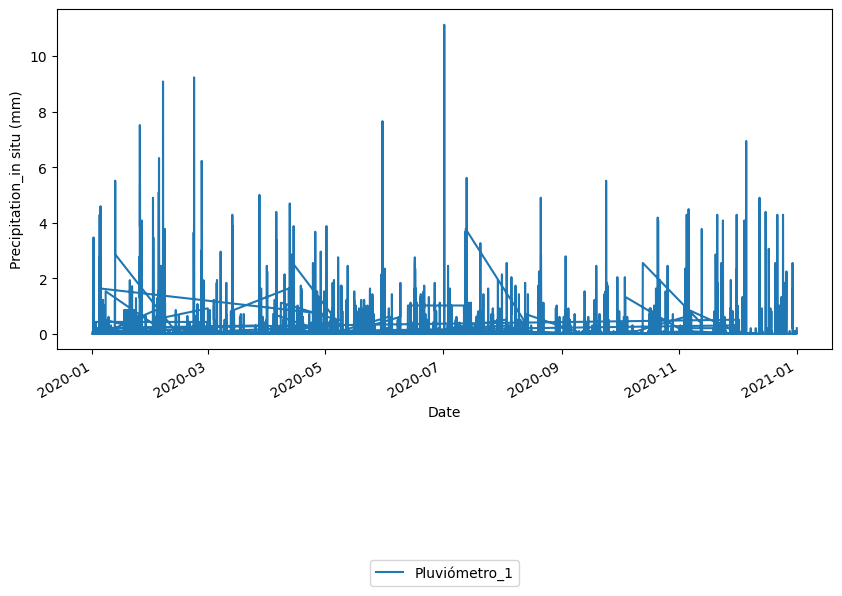

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

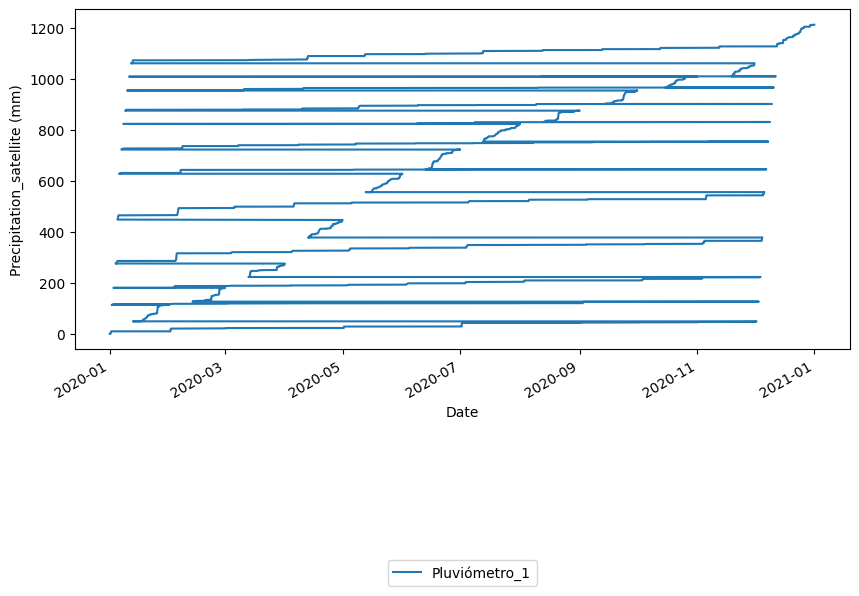

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

In [3]:
#the import for rauge gauge_2
import pandas as pd # Import the pandas library and assign it to the alias 'pd'
folder_pcp_2 = '/content/Rain_gauge_2.csv'
df_pcp_2= pd.read_table('/content/Rain_gauge_2.csv',sep=',')
df_pcp_2

,Date,Precipitation
0,2013-03-07 17:00:00,0.000000
1,2013-03-07 18:00:00,0.000000
2,2013-03-07 19:00:00,0.000000
3,2013-03-07 20:00:00,0.000000
4,2013-03-07 21:00:00,0.000000
...,...,...
94125,2023-12-02 14:00:00,0.000000
94126,2023-12-02 15:00:00,0.000000
94127,2023-12-02 16:00:00,0.000000
94128,2023-12-02 17:00:00,0.000000


In [4]:
#operation parameters on dataframe manageable
df_pcp_2['Date'] = df_pcp_2.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_2.set_index(df_pcp_2['Date'],inplace=True)
df_pcp_2.rename(columns={'Precipitation':'Pluviómetro_2'},inplace=True)
df_pcp_2 = df_pcp_2.drop(labels='Date', axis=1)
df_pcp_2

<ipython-input-4-67968bce84ca>:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_pcp_2['Date'] = df_pcp_2.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))


,Pluviómetro_2
Date,
2013-07-03 17:00:00,0.000000
2013-07-03 18:00:00,0.000000
2013-07-03 19:00:00,0.000000
2013-07-03 20:00:00,0.000000
2013-07-03 21:00:00,0.000000
...,...
2023-02-12 14:00:00,0.000000
2023-02-12 15:00:00,0.000000
2023-02-12 16:00:00,0.000000


In [11]:
# Reset the index to bring 'Date' back as a column:
df_pcp_2 = df_pcp_2.reset_index()
# Now you can apply the pd.to_datetime function to the 'Date' column:
df_pcp_2['Date'] = df_pcp_2['Date'].apply(lambda x: pd.to_datetime(x,dayfirst=True))

In [12]:
df_pcp_2.set_index(df_pcp_2['Date'],inplace=True)
df_pcp_2.rename(columns={'Precipitation':'Pluviómetro_2'},inplace=True)
df_pcp_2 = df_pcp_2.drop(labels='Date', axis=1)
df_pcp_2

,Pluviómetro_2
Date,
2013-07-03 17:00:00,0.000000
2013-07-03 18:00:00,0.000000
2013-07-03 19:00:00,0.000000
2013-07-03 20:00:00,0.000000
2013-07-03 21:00:00,0.000000
...,...
2023-02-12 14:00:00,0.000000
2023-02-12 15:00:00,0.000000
2023-02-12 16:00:00,0.000000


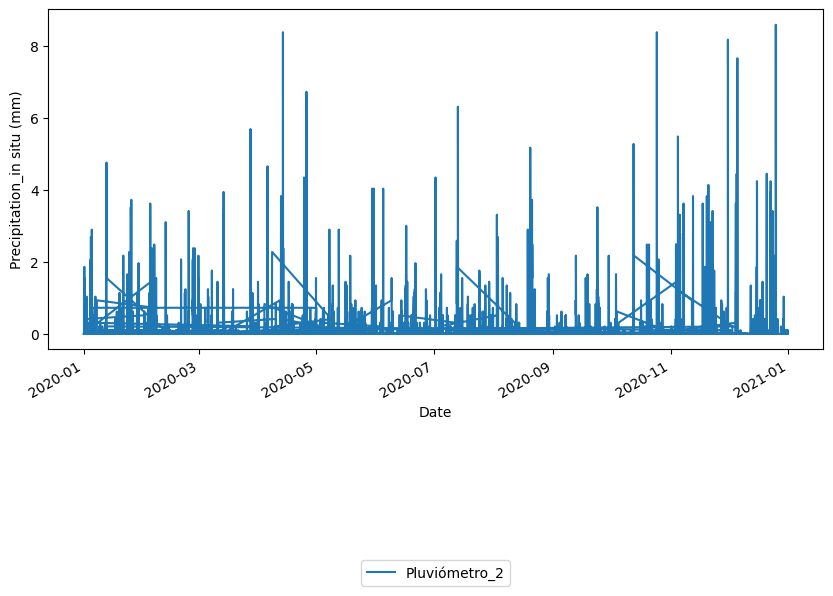

In [13]:
#Plot the year 2020 imported series
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

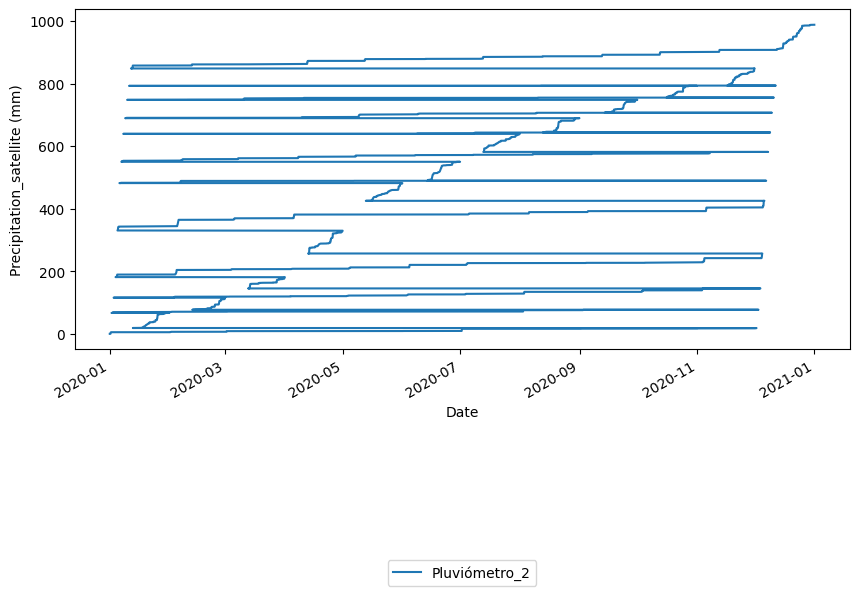

In [14]:
#plot accummulated precipitation for the 2020 years from imported series
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

In [15]:
#Rauge_3  import and process data
folder_pcp_3 = '/content/Rain_gauge_3.csv'
df_pcp_3= pd.read_table('/content/Rain_gauge_3.csv', sep=',')
df_pcp_3

,Fecha,Precipitation
0,2012-09-27 12:00:00,0.108980
1,2012-09-27 13:00:00,4.904100
2,2012-09-27 14:00:00,2.724500
3,2012-09-27 15:00:00,2.179600
4,2012-09-27 16:00:00,0.544900
...,...,...
97994,2023-12-02 14:00:00,0.000000
97995,2023-12-02 15:00:00,0.245533
97996,2023-12-02 16:00:00,0.000000
97997,2023-12-02 17:00:00,0.000000


In [16]:
#operation to create mangeable dataframe
df_pcp_3['Fecha'] = df_pcp_3.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_3.set_index(df_pcp_3['Fecha'],inplace=True)
df_pcp_3 = df_pcp_3.drop(labels='Fecha', axis=1)
df_pcp_3.rename(columns={'Precipitation':'Pluviómetro_3'},inplace=True)
df_pcp_3

<ipython-input-16-c78da5b6fe74>:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_pcp_3['Fecha'] = df_pcp_3.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))


,Pluviómetro_3
Fecha,
2012-09-27 12:00:00,0.108980
2012-09-27 13:00:00,4.904100
2012-09-27 14:00:00,2.724500
2012-09-27 15:00:00,2.179600
2012-09-27 16:00:00,0.544900
...,...
2023-02-12 14:00:00,0.000000
2023-02-12 15:00:00,0.245533
2023-02-12 16:00:00,0.000000


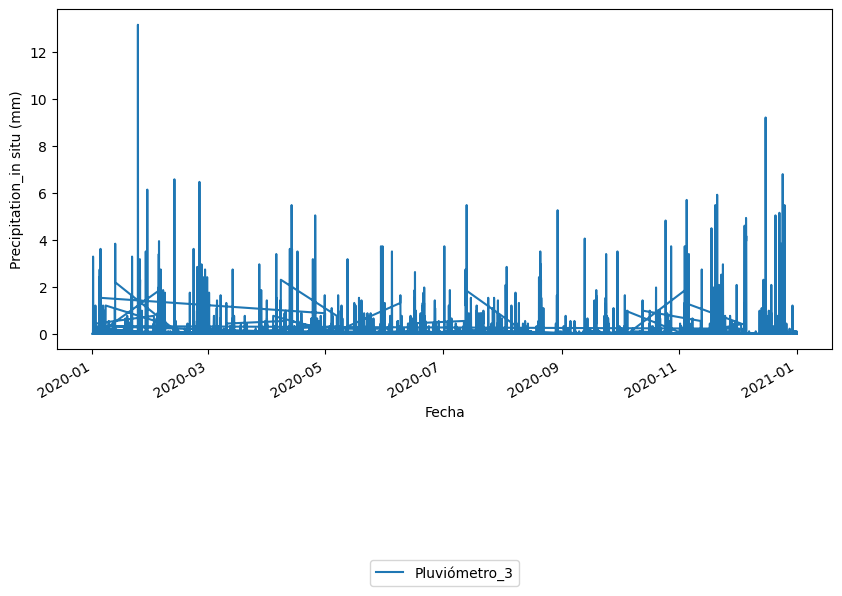

In [17]:
#Plot preciptation for the year 2020
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

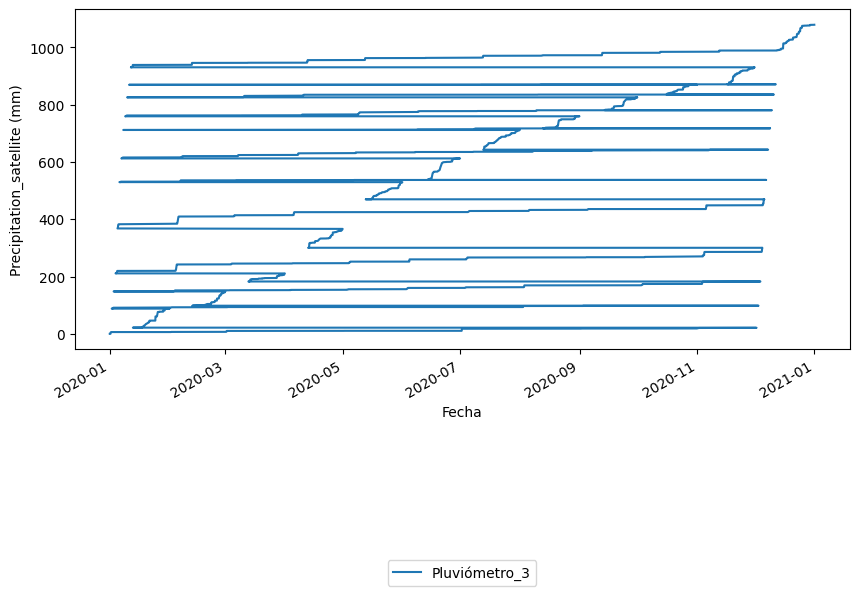

In [18]:
#plot accumulated precipation for the year 2020
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

In [20]:
#Compare the in-situ precipitation
#Resample the data from the 3 rain gauges to monthly scales.
# Import pandas if it hasn't been imported yet
import pandas as pd

# Load the data for df_pcp_1
folder_pcp_1 = '/content/Rain_gauge_1.csv'  # Adjust path if needed
df_pcp_1 = pd.read_table(folder_pcp_1, sep=',')
df_pcp_1.rename(columns={'Texas_tip_corrected_mm': 'Pluviómetro_1'}, inplace=True)
df_pcp_1.rename(columns={'Date_yy/mm/dd_hh:mm:ss': 'Date'}, inplace=True)
df_pcp_1['Date'] = df_pcp_1['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
df_pcp_1.set_index('Date', inplace=True)

# Now proceed with the resampling
df_pcp_1_monthly = df_pcp_1.resample('M', label='right', closed='right').sum()
df_pcp_1_monthly = df_pcp_1_monthly.groupby(df_pcp_1_monthly.index.month).mean()
df_pcp_2_monthly = df_pcp_2.resample('M', label='right', closed='right').sum()
df_pcp_2_monthly = df_pcp_2_monthly.groupby(df_pcp_2_monthly.index.month).mean()
df_pcp_3_monthly = df_pcp_3.resample('M', label='right', closed='right').sum()
df_pcp_3_monthly = df_pcp_3_monthly.groupby(df_pcp_3_monthly.index.month).mean()
all_pcp_monthly = pd.concat([df_pcp_1_monthly, df_pcp_2_monthly, df_pcp_3_monthly], axis=1)

<ipython-input-20-680d61b524e0>:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_pcp_1['Date'] = df_pcp_1['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
<ipython-input-20-680d61b524e0>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_pcp_1_monthly = df_pcp_1.resample('M', label='right', closed='right').sum()
<ipython-input-20-680d61b524e0>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_pcp_2_monthly = df_pcp_2.resample('M', label='right', closed='right').sum()
<ipython-input-20-680d61b524e0>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_pcp_3_monthly = df_pcp_3.resample('M', label='right', closed='right').sum()


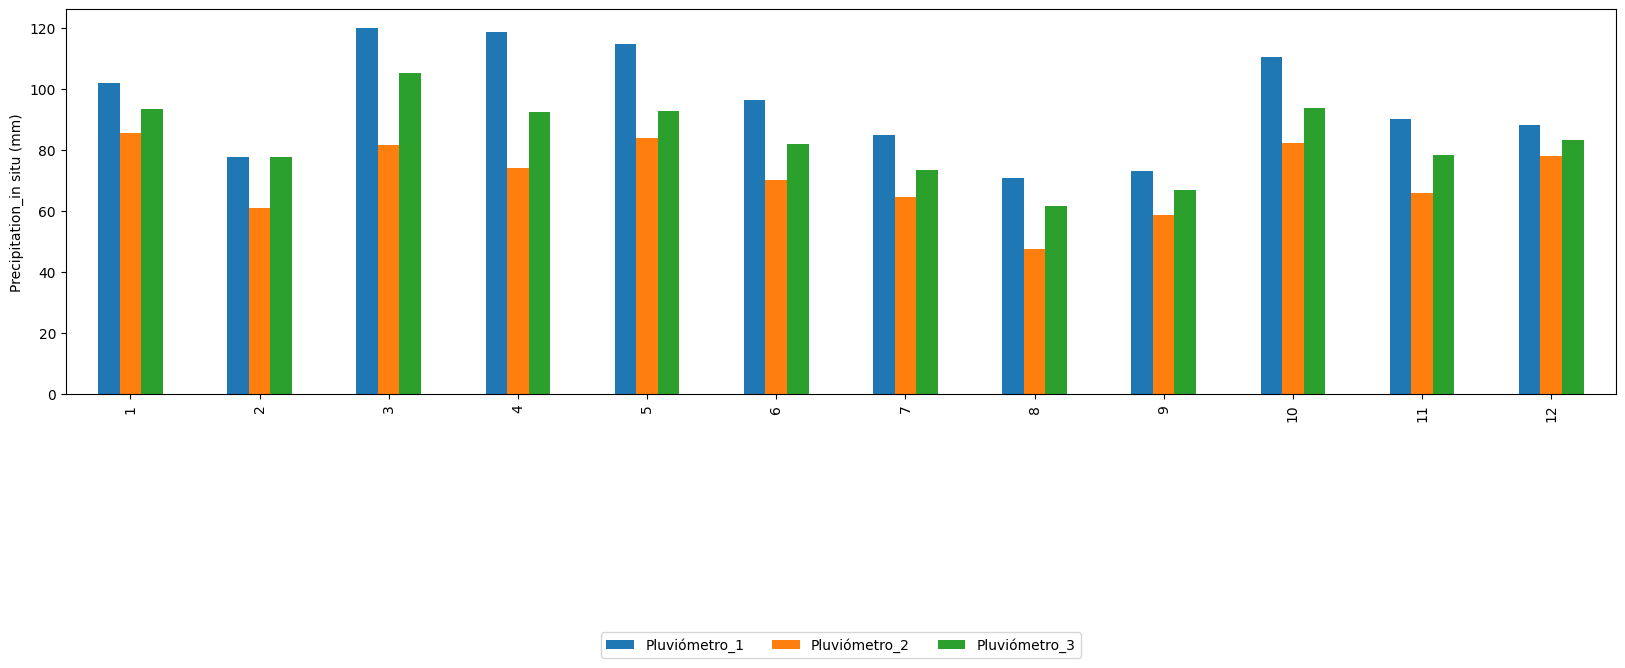

In [21]:
#plot
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
all_pcp_monthly.plot(kind='bar',ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

In [22]:
#Import runoff data
#import and organize runoff data in a manageable dataframe
folder_runoff = '/content/Runoff_catchment_1.xlsx/'
df_runoff =  pd.read_excel('/content/Runoff_catchment_1.xlsx')
df_runoff['Fecha'] = df_runoff.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_runoff.set_index(df_runoff['Fecha'],inplace=True)
df_runoff = df_runoff.drop(labels='Fecha', axis=1)
df_runoff

,Caudal (m3/s)
Fecha,
1997-07-17 20:00:00,5.756145
1997-07-17 21:00:00,5.756145
1997-07-17 22:00:00,5.756145
1997-07-17 23:00:00,5.977188
1997-07-18 00:00:00,5.756145
...,...
2021-07-05 06:59:00,0.738076
2021-07-05 07:59:00,0.738934
2021-07-05 08:59:00,0.736365


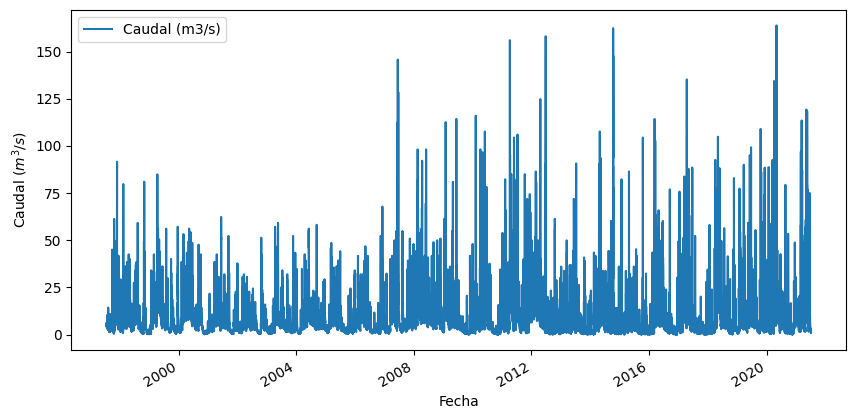

In [23]:
#Plot
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_runoff.plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')
# Adjusting the position of the legend
plt.legend()
plt.show()


In [24]:
# Combine precipitation (rain gauges + satellite) and flow data for the catchment
df_pcp_1_daily = df_pcp_1.resample('D',label='right',closed='right').sum()
df_pcp_2_daily = df_pcp_2.resample('D',label='right',closed='right').sum()
df_pcp_3_daily = df_pcp_3.resample('D',label='right',closed='right').sum()
df_runoff_daily = df_runoff.resample('D',label='right',closed='right').mean()
all_data_daily = pd.concat([df_pcp_1_daily, df_pcp_2_daily, df_pcp_3_daily, precipitation_satellite, df_caudal_daily], axis=1)
all_data_daily

NameError: name 'precipitation_satellite' is not defined

In [25]:
# Combine precipitation (rain gauges + satellite) and flow data for the catchment
df_pcp_1_daily = df_pcp_1.resample('D',label='right',closed='right').sum()
df_pcp_2_daily = df_pcp_2.resample('D',label='right',closed='right').sum()
df_pcp_3_daily = df_pcp_3.resample('D',label='right',closed='right').sum()
df_runoff_daily = df_runoff.resample('D',label='right',closed='right').mean()

# Re-importing/defining precipitation_satellite
# Import satellite precipitation data by taking the correct file path
precipitation_satellite = pd.read_table('/content/PERSIANN-CCS_UTC_daily_catchment_1.csv', sep=',')
# Rename columns
precipitation_satellite.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
# Convert the 'Date' column to datetime format
precipitation_satellite['Date'] = precipitation_satellite['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
# Set 'Date' as the index
precipitation_satellite.set_index(precipitation_satellite['Date'], inplace=True)
# Drop the redundant 'Date' column (updated for future pandas versions)
precipitation_satellite = precipitation_satellite.drop(labels='Date', axis=1)

all_data_daily = pd.concat([df_pcp_1_daily, df_pcp_2_daily, df_pcp_3_daily, precipitation_satellite, df_runoff_daily], axis=1) #df_caudal_daily was changed to df_runoff_daily
all_data_daily

<ipython-input-25-5d0bb392ae44>:13: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  precipitation_satellite['Date'] = precipitation_satellite['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))


,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,22,23,24,25,26,27,28,31,32,Caudal (m3/s)
1997-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.800354
1997-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.510110
1997-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.573900
1997-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.166181
1997-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.233679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-08,0.73794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2023-12-09,0.00000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-10,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-11,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NameError: name 'np' is not defined

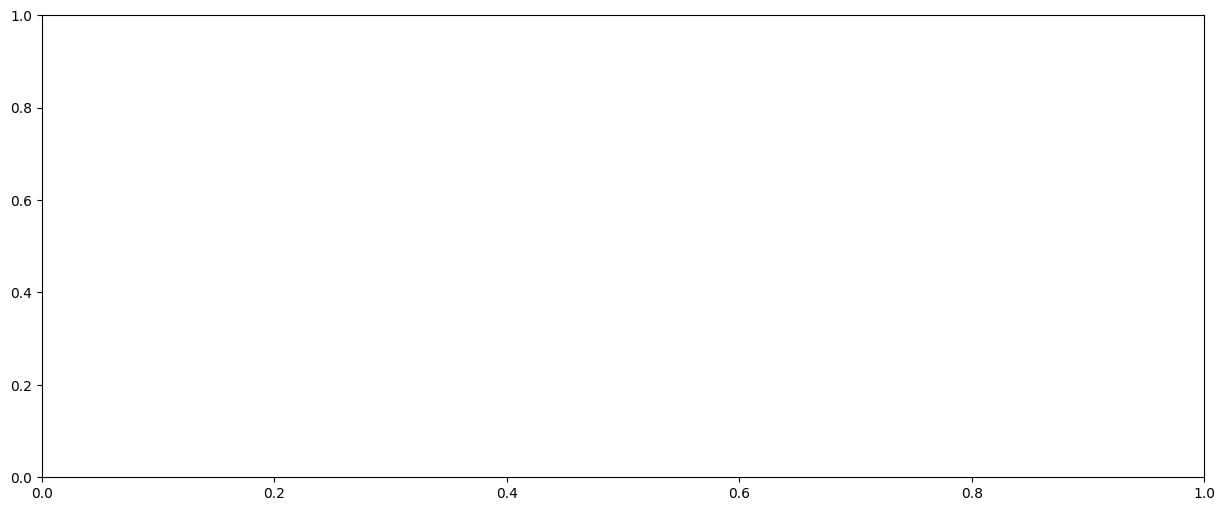

In [27]:
#Determine periods with concurrent data
concurrent_periods = all_data_daily.dropna().index

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through columns
for i, col in enumerate(all_data_daily.columns):
    # Get a boolean mask where data is not NaN for the current column
    mask = ~all_data_daily[col].isna()

    # Get the indices of True values in the mask
    indices = np.where(mask)[0]

    # Plot horizontal lines for continuity
    ax.hlines(i, indices[0], indices[-1], colors='0.1', linewidth=5, label=col)

# Set y-ticks and labels
ax.set_yticks(range(len(all_data_daily.columns)))
ax.set_yticklabels(all_data_daily.columns)
# Set x-axis label
ax.set_xlabel('Date')

# Set the x-axis ticks to show years
years = pd.to_datetime(all_data_daily.index).year
unique_years = np.unique(years)
ax.set_xticks(np.arange(len(all_data_daily.index), step=365))
ax.set_xticklabels(unique_years,rotation=45)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=11)

# Show the plot
plt.show()

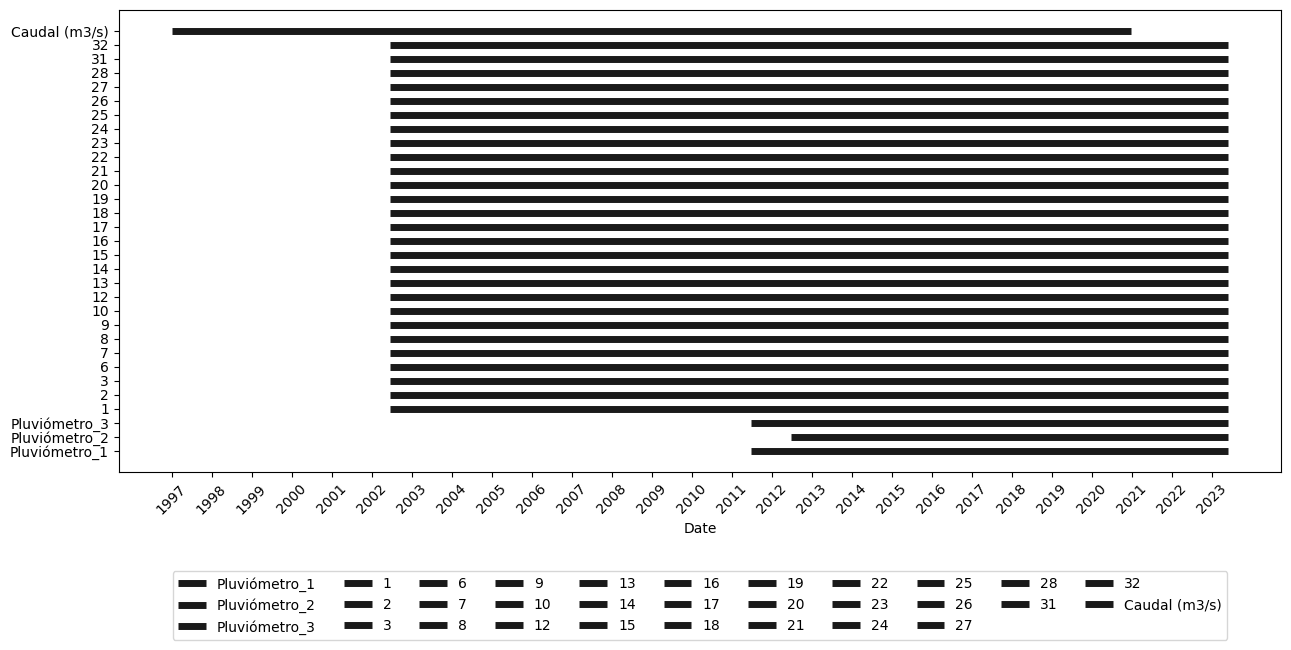

In [28]:
#Determine periods with concurrent data
import numpy as np # Import numpy with the alias 'np'

concurrent_periods = all_data_daily.dropna().index

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through columns
for i, col in enumerate(all_data_daily.columns):
    # Get a boolean mask where data is not NaN for the current column
    mask = ~all_data_daily[col].isna()

    # Get the indices of True values in the mask
    indices = np.where(mask)[0]

    # Plot horizontal lines for continuity
    ax.hlines(i, indices[0], indices[-1], colors='0.1', linewidth=5, label=col)

# Set y-ticks and labels
ax.set_yticks(range(len(all_data_daily.columns)))
ax.set_yticklabels(all_data_daily.columns)
# Set x-axis label
ax.set_xlabel('Date')

# Set the x-axis ticks to show years
years = pd.to_datetime(all_data_daily.index).year
unique_years = np.unique(years)
ax.set_xticks(np.arange(len(all_data_daily.index), step=365))
ax.set_xticklabels(unique_years,rotation=45)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=11)

# Show the plot
plt.show()

## Split the data into training and test periods

In [29]:
all_data_daily = all_data_daily[~(all_data_daily.isna().any(axis=1) | (all_data_daily.lt(0).any(axis=1)))]
input_data_train = np.array(all_data_daily['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(all_data_daily['2020':'2021-06'].iloc[:,:-1])

In [30]:
input_data_train

array([[ 7.1274 ,  0.     ,  4.57716, ...,  0.     ,  0.     ,  0.     ],
       [ 3.86916,  0.10991,  2.07062, ...,  0.     ,  0.     ,  0.     ],
       [ 2.13822,  0.     ,  0.21796, ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 2.0434 ,  5.166  ,  5.91354, ...,  0.     ,  0.     ,  0.     ],
       [ 1.53255,  2.583  ,  1.42363, ...,  0.     ,  0.     ,  0.     ],
       [12.56691,  7.12908,  8.32276, ...,  0.     ,  0.     ,  0.     ]])

In [31]:
output_data_train = np.reshape(np.array(all_data_daily['2013':'2019'].iloc[:,-1]),(all_data_daily['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily['2020':'2021-06'].iloc[:,-1]),(all_data_daily['2020':'2021-06'].shape[0],1))

In [32]:
output_data_train


array([[ 6.436433  ],
       [31.6041108 ],
       [19.21637896],
       ...,
       [ 1.45913546],
       [ 2.10672294],
       [ 3.40283158]])

In [33]:
input_data_train_lags, output_data_train_lags= lagged_dataset(input_data_train, 3, output_data_train,15)

NameError: name 'lagged_dataset' is not defined

In [34]:
def lagged_dataset(arr, num_steps, additional_arr, new_num_steps):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []
    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)
    result_array = np.array(modified_rows)
    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row[:-1]))  # Exclude last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    return final_result, np.array(excluded_data)[:, None]

In [35]:
input_data_train_lags


NameError: name 'input_data_train_lags' is not defined

In [36]:
input_data_train_lags, output_data_train_lags= lagged_dataset(input_data_train, 3, output_data_train,15)

In [37]:
input_data_train_lags

array([[ 0.61092   ,  0.        ,  0.21796   , ...,  2.55601433,
         2.23686872,  3.72926551],
       [11.91294   ,  0.        ,  0.        , ...,  2.23686872,
         3.72926551,  3.36018271],
       [10.38564   ,  0.        ,  1.30776   , ...,  3.72926551,
         3.36018271,  2.06741952],
       ...,
       [ 1.12387   ,  0.30996   ,  0.65706   , ...,  1.66572182,
         1.48337555,  1.68993365],
       [ 1.22604   ,  0.5166    ,  0.76657   , ...,  1.48337555,
         1.68993365,  1.45913546],
       [ 1.32821   ,  2.89296   ,  4.48991   , ...,  1.68993365,
         1.45913546,  2.10672294]])

In [38]:
output_data_train_lags

array([[3.36018271],
       [2.06741952],
       [1.5540511 ],
       ...,
       [1.45913546],
       [2.10672294],
       [3.40283158]])

In [39]:
input_data_test_lags, output_data_test_lags= lagged_dataset(input_data_test, 3, output_data_test,15)

In [40]:
input_data_test_lags

array([[ 0.2149266 ,  0.10332   ,  0.        , ..., 11.6085901 ,
         5.40761042,  4.09615773],
       [ 0.8597064 ,  1.44648   ,  4.3804    , ...,  5.40761042,
         4.09615773,  3.26299964],
       [ 0.2149266 ,  2.0664    ,  6.24207   , ...,  4.09615773,
         3.26299964,  2.38323539],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  5.4826092 ,
         4.08104159,  3.43069775],
       [ 0.84336   ,  1.641795  ,  1.11362   , ...,  4.08104159,
         3.43069775,  2.81574878],
       [ 0.5271    ,  3.830855  ,  4.009032  , ...,  3.43069775,
         2.81574878,  2.05206994]])

## Creation and training of a Random Forest model (not forecasting)


In [41]:
output_data_test_lags

array([[3.26299964e+00],
       [2.38323539e+00],
       [2.04150960e+00],
       [2.12740993e+00],
       [1.97586372e+00],
       [1.56266220e+00],
       [1.32490767e+00],
       [9.13074435e-01],
       [7.42564058e-01],
       [7.29255890e-01],
       [7.38267416e-01],
       [7.52041606e-01],
       [5.78568778e-01],
       [4.32383611e-01],
       [4.39384755e-01],
       [4.00086486e-01],
       [3.26506799e-01],
       [2.92573230e-01],
       [2.74681703e-01],
       [2.75181926e-01],
       [3.07345269e-01],
       [3.52692385e-01],
       [3.30488928e-01],
       [5.53051936e-01],
       [2.19522790e+00],
       [3.08987012e+00],
       [2.11562740e+00],
       [6.28034282e+00],
       [2.09868030e+01],
       [8.33435695e+00],
       [3.53802989e+00],
       [2.64702828e+00],
       [2.64398203e+00],
       [4.18060501e+00],
       [2.60989310e+00],
       [2.43471332e+00],
       [3.64091264e+00],
       [4.19450282e+00],
       [1.06584314e+01],
       [5.44914454e+00],


### Define model hyperparameters

In [42]:
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'

In [44]:
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)

NameError: name 'RandomForestRegressor' is not defined

In [45]:
# Make sure to import the necessary class, in case it wasn't imported previously:
from sklearn.ensemble import RandomForestRegressor

# Define model hyperparameters
min_samples_splt = 10
min_samples_lf = 4
max_dpth = 350
n_trees = 600
max_ft = 'sqrt'

# Create the RandomForestRegressor object
regr = RandomForestRegressor(bootstrap=True, min_samples_split=min_samples_splt,
                               max_depth=max_dpth, max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees, oob_score=True, n_jobs=-1,
                               warm_start=True, random_state=22)

In [46]:
#Training Model
# Correcting the shape of output_data_train_lags
regr = regr.fit(input_data_train_lags, output_data_train_lags.ravel())

In [47]:
#Generation of simulation training period
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
simulations_data_train

array([[4.17981898],
       [2.91359287],
       [2.10564686],
       ...,
       [2.16285038],
       [2.46414749],
       [4.19525905]])

Generate simuklation for testing period

In [48]:
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
simulations_data_test

array([[ 6.98941862],
       [ 6.00227143],
       [ 5.23642901],
       [ 6.16366933],
       [ 5.67575659],
       [12.06922468],
       [13.65736955],
       [ 9.94662543],
       [ 6.63414155],
       [ 4.3743717 ],
       [ 1.80496877],
       [ 0.99975616],
       [ 1.01047988],
       [ 1.41152429],
       [ 1.40939738],
       [ 1.19955937],
       [ 0.70950544],
       [ 0.48708906],
       [ 0.32839231],
       [ 0.29929975],
       [ 0.57116504],
       [ 1.20195877],
       [ 1.17090857],
       [ 2.31803777],
       [ 2.529352  ],
       [ 2.55638112],
       [ 3.10463517],
       [ 4.72944822],
       [ 6.88830153],
       [ 9.76084401],
       [ 7.97780701],
       [ 6.29270035],
       [ 5.21302433],
       [ 3.73245218],
       [ 3.43056837],
       [ 3.74917479],
       [ 4.20575477],
       [ 4.74390903],
       [ 4.53523112],
       [ 7.098614  ],
       [ 6.18718607],
       [ 5.17034831],
       [ 6.17071045],
       [ 9.54617157],
       [13.82920594],
       [14

Model evaluation

In [50]:
#Calculate the correlation coeffiecent for the training and testing period
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.8144117322611889 0.5111715393432605


## Creation and training of a random forest model (forecasting)

In [52]:
#One-day forecasting case
def lagged_dataset_pron(arr, num_steps, additional_arr, new_num_steps, lead_time):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []

    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)

    result_array = np.array(modified_rows)

    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row))  # Include last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Shift excluded_data by lead_time
    excluded_data = excluded_data[lead_time:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    # Resize final_result and excluded_data to have the same number of rows
    min_rows = min(final_result.shape[0], excluded_data.shape[0])
    final_result = final_result[:min_rows]
    excluded_data = excluded_data[:min_rows]

    return final_result, np.array(excluded_data)[:, None]
leadtime = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 7, output_data_train,15, lead_time=leadtime)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 7, output_data_test,15, lead_time=leadtime)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=42)
regr=regr.fit(input_data_train_lags, output_data_train_lags.ravel())
#Prediction on training data
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.7788174861748993 0.4418336604208286


### Forecasts in the testing period

In [53]:
simulations_data_test

array([[ 8.02386505],
       [ 6.59885904],
       [ 7.87660208],
       [ 6.47415022],
       [ 7.35870649],
       [10.01414469],
       [10.21632939],
       [ 7.19517469],
       [ 6.29990673],
       [ 3.59706203],
       [ 2.46107442],
       [ 2.12300902],
       [ 1.96543358],
       [ 2.20918734],
       [ 1.3396726 ],
       [ 0.92445667],
       [ 0.72445968],
       [ 0.71868769],
       [ 0.64102968],
       [ 0.469227  ],
       [ 1.11052821],
       [ 1.46832513],
       [ 1.43003378],
       [ 2.6913171 ],
       [ 2.9632227 ],
       [ 3.28542757],
       [ 4.04532758],
       [ 8.17232916],
       [11.16334724],
       [ 9.55820833],
       [ 7.89005815],
       [ 6.74378723],
       [ 4.71408715],
       [ 4.43692855],
       [ 4.24661472],
       [ 5.11227678],
       [ 4.53490435],
       [ 4.7278227 ],
       [ 7.48183305],
       [ 5.84753006],
       [ 5.75116234],
       [ 6.98127872],
       [ 6.98727152],
       [13.38325923],
       [13.32562088],
       [ 9

##Evaluation using a combination of efficiency metrics

In [55]:
def calculate_hydro_metrics(simulations, evaluation):
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    rmse = np.sqrt(np.mean((evaluation - simulations) ** 2,
                            axis=0, dtype=np.float64))
    pbias = (100 * np.sum(evaluation - simulations, axis=0, dtype=np.float64)
              / np.sum(evaluation))
    r2 = 1 - (np.sum((evaluation - simulations)**2) / np.sum((evaluation - np.mean(evaluation))**2))
    return kge, rmse, pbias, r2

# ... (rest of your existing code) ...

kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 8.3145
PBias: 8.8257
KGE: 0.3808
R2: 0.4418


In [ ]:
### Evaluation through visual inspection
### One-Day runoff forecasts

In [56]:
simulations_data_test = pd.DataFrame(simulations_data_test, columns=['Forecasts'], index=all_data_daily['2019':'2021-06'].index[-len(simulations_data_test):])


### And the runoff observations

In [57]:
observations_data_test = pd.DataFrame(output_data_test_lags, columns=['Observations'], index=all_data_daily['2019':'2021-06'].index[-len(output_data_test_lags):])
observations_data_test

,Observations
2020-02-01,2.383235
2020-02-02,2.041510
2020-02-03,2.127410
2020-02-04,1.975864
2020-02-05,1.562662
...,...
2021-06-26,4.081042
2021-06-27,3.430698
2021-06-28,2.815749
2021-06-29,2.052070


### Combine forecasts and observations into a DataFrame

In [58]:
testing_period = pd.concat([simulations_data_test, observations_data_test], axis=1)

In [59]:
testing_period

,Forecasts,Observations
2020-02-01,8.023865,2.383235
2020-02-02,6.598859,2.041510
2020-02-03,7.876602,2.127410
2020-02-04,6.474150,1.975864
2020-02-05,7.358706,1.562662
...,...,...
2021-06-26,6.778513,4.081042
2021-06-27,6.346875,3.430698
2021-06-28,5.678353,2.815749
2021-06-29,4.807648,2.052070


### Plot (compare) forecasts and observations

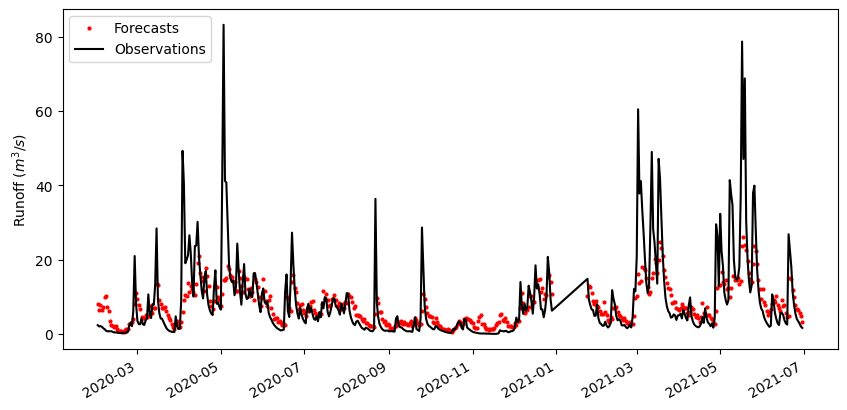

In [60]:
fig, ax= plt.subplots(figsize=(10, 5))

# Assuming testing_period is a pandas DataFrame with labeled columns
testing_period['Forecasts'].plot(color='red', marker='o', linestyle='', markersize=2)
testing_period['Observations'].plot( color='black', linestyle='-')

# Adding a label to the y-axis
plt.ylabel('Runoff ($m^3/s$)')

# Adjusting the position of the legend
plt.legend()

plt.show()

### Scatter plot of forecasts and observations

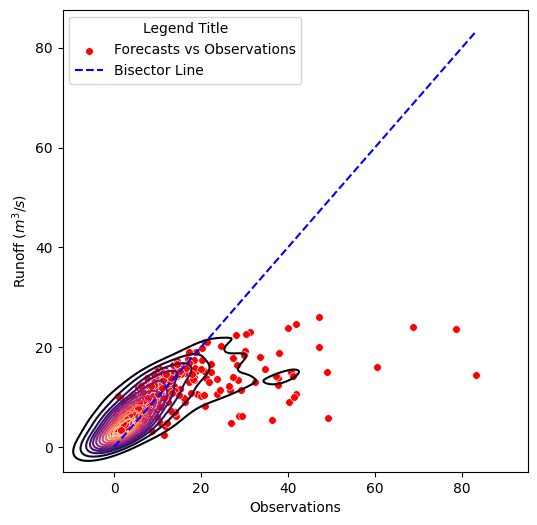

In [62]:
# Assuming testing_period is a pandas DataFrame with labeled columns
import seaborn as sns # Import seaborn library
fig, ax = plt.subplots(figsize=(6, 6))
# Scatter plot for Observaciones
x = testing_period['Observations']
y = testing_period['Forecasts']
sns.scatterplot(x=x, y=y, color='red', marker='o', s=30, label='Forecasts vs Observations', ax=ax)
# KDE plot for density
# Assuming x and y are your data arrays
# Concatenate x and y into a single array
data = np.vstack((x, y)).T
sns.kdeplot(x=x,y=y,cmap='magma', ax=ax, fill=False, thresh=0, levels=13, legend=False)
# Add a bisector line (y = x)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Bisector Line')
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
ax.set_ylabel('Runoff ($m^3/s$)')
# Show the plot
plt.show()

## Include ENSO data

https://psl.noaa.gov/gcos_wgsp/Timeseries/

Import data

In [64]:
# Define the path to
folder_nino12 = '/content/nino12.long.anom.data.xlsx'
folder_nino3 = '/content/nino3.long.anom.data.xlsx'
folder_nino34 = '/content/nino34.long.anom.data.xlsx'

In [65]:
# Use tabula to extract tables
nino12 =  pd.read_excel(folder_nino12)
nino3 =  pd.read_excel(folder_nino3)
nino34 =  pd.read_excel(folder_nino34)

In [66]:
# Melt the DataFrame to convert it to long format
nino12_long = nino12.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino12_long['Data'] = nino12_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino12_long['Date'] = pd.to_datetime(nino12_long['Year'].astype(str) + '-' + nino12_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino12_time_series = nino12_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino12_time_series

# Melt the DataFrame to convert it to long format
nino3_long = nino3.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino3_long['Data'] = nino3_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino3_long['Date'] = pd.to_datetime(nino3_long['Year'].astype(str) + '-' + nino3_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino3_time_series = nino3_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino3_time_series

# Melt the DataFrame to convert it to long format
nino34_long = nino34.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino34_long['Data'] = nino34_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino34_long['Date'] = pd.to_datetime(nino34_long['Year'].astype(str) + '-' + nino34_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino34_time_series = nino34_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino34_time_series

,Data
Date,
1870-01-01,-1.00
1871-01-01,-0.25
1872-01-01,-0.72
1873-01-01,-0.78
1874-01-01,-0.93
...,...
2019-12-01,0.51
2020-12-01,-0.98
2021-12-01,-1.07


### Convert monthly data to daily data

In [67]:
nino12_df = nino12_time_series.resample('D').ffill()
nino3_df = nino3_time_series.resample('D').ffill()
nino34_df = nino34_time_series.resample('D').ffill()

In [68]:
ENSO_daily = pd.concat([nino12_df,nino3_df,nino34_df], axis=1)
ENSO_daily

,Data,Data,Data
Date,,,
1870-01-01,-1.5,-1.35,-1.0
1870-01-02,-1.5,-1.35,-1.0
1870-01-03,-1.5,-1.35,-1.0
1870-01-04,-1.5,-1.35,-1.0
1870-01-05,-1.5,-1.35,-1.0
...,...,...,...
2023-11-27,NaN,NaN,NaN
2023-11-28,NaN,NaN,NaN
2023-11-29,NaN,NaN,NaN


### Combine all Information

In [69]:
all_data_daily_ENSO = pd.concat([all_data_daily, ENSO_daily], axis=1)
all_data_daily_ENSO

,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,25,26,27,28,31,32,Caudal (m3/s),Data,Data,Data
1870-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define Training and Testing Periods

In [70]:
ll_data_daily_ENSO = all_data_daily_ENSO[~(all_data_daily_ENSO.isna().any(axis=1))]
all_data_daily_ENSO.shape
inputs = all_data_daily_ENSO.drop(all_data_daily_ENSO.columns[-4], axis=1)
input_data_train = np.array(inputs['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(inputs['2020':'2021-06'].iloc[:,:-1])
output_data_train = np.reshape(np.array(all_data_daily_ENSO['2013':'2019'].iloc[:,-4]),(all_data_daily_ENSO['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily_ENSO['2020':'2021-06'].iloc[:,-4]),(all_data_daily_ENSO['2020':'2021-06'].shape[0],1))

In [71]:
input_data_train

array([[     nan,      nan,      nan, ...,      nan, -0.7    , -0.59   ],
       [     nan,      nan,      nan, ...,      nan, -0.7    , -0.59   ],
       [     nan,      nan,      nan, ...,      nan, -0.7    , -0.59   ],
       ...,
       [ 2.0434 ,  5.166  ,  5.91354, ...,  0.     , -0.19   ,  0.25   ],
       [ 1.53255,  2.583  ,  1.42363, ...,  0.     , -0.19   ,  0.25   ],
       [12.56691,  7.12908,  8.32276, ...,  0.     , -0.19   ,  0.25   ]])

In [72]:
output_data_test

array([[1.53248767e+01],
       [1.58211567e+01],
       [1.42347386e+01],
       [1.26846169e+01],
       [6.87607984e+00],
       [4.76350963e+00],
       [4.18824255e+00],
       [3.38542495e+00],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [4.93260764e+00],
       [4.85179543e+00],
       [1.79362249e+01],
       [2.34326570e+01],
       [1.16085901e+01],
       [5.40761042e+00],
       [4.09615773e+00],
       [3.26299964e+00],
       [2.38323539e+00],
       [2.04150960e+00],
       [2.12740993e+00],
       [1.97586372e+00],
       [1.56266220e+00],
       [1.32490767e+00],
       [9.13074435e-01],
       [7.42564058e-01],
       [7.29255890e-01],


## Development of one-day forecasting models

In [ ]:
leadtime = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 3, output_data_train,15, lead_time=leadtime)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 3, output_data_test,15, lead_time=leadtime)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)
regr=regr.fit(input_data_train_lags, output_data_train_lags.ravel())
#Prediction on training data
simulations_data_train_ENSO= regr.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= regr.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)